<a href="https://colab.research.google.com/github/ritiknayakzz/Rossmann-Sales-Prediction-Regression-Project/blob/main/Regression_Capstone_Project_(Rossmann_Sales_Prediction)_Ritik_Prakash_Nayak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from matplotlib import style

style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (15, 8)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.imputation import mice

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Capstone Projects/Retail Sales Prediction/Data & Resources/Rossmann Stores Data.csv",
                 low_memory = False, parse_dates = ['Date'])
stores = pd.read_csv("/content/drive/MyDrive/Capstone Projects/Retail Sales Prediction/Data & Resources/store.csv")

In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
print("The shape of Rossmann Stores Data is: {}".format(df.shape))
print("The shape of the Stores Data is: {}".format(stores.shape))

The shape of Rossmann Stores Data is: (1017209, 9)
The shape of the Stores Data is: (1115, 10)


In [7]:
print(df.isna().sum())
print('--------------------------------')
print(stores.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
--------------------------------
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


***Let's focus only on the 'df' dataset first***

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


All variables but 'Date', and 'StateHoliday' have integers. 'Date' is a datatime whereas 'StateHoliday' is an object 

**1. Day of week**

In [9]:
print(df['DayOfWeek'].value_counts().sort_index())
print('-----------------------------------------')
print(df['DayOfWeek'].value_counts(normalize = True).sort_values())

1    144730
2    145664
3    145665
4    145845
5    145845
6    144730
7    144730
Name: DayOfWeek, dtype: int64
-----------------------------------------
1    0.142281
7    0.142281
6    0.142281
2    0.143200
3    0.143201
5    0.143378
4    0.143378
Name: DayOfWeek, dtype: float64


This variable is clearly a count. The highest value is 7 and the lowest value is one. For this variable, a reexpression will not help much as the ratio between the largest and the smallest values is quite low - 7. So, we'll explore the variable as it is.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(144500.0, 146000.0)

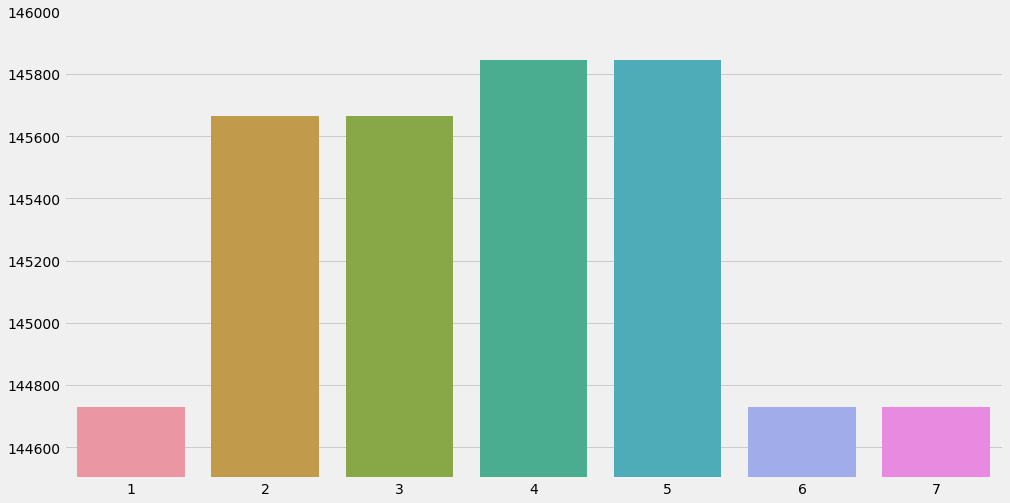

In [10]:
x = df['DayOfWeek'].value_counts().sort_index().index
y = df['DayOfWeek'].value_counts().sort_index().values

sns.barplot(x, y)
plt.ylim([144500, 146000])

Apparently, all the weeks are almost equally distributed. One cannot tell on which week days is the customer turn out the most.  

**2. Customers**

In [11]:
print(df['Customers'].describe())
print('-----------------------------------------')
print(df['Customers'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64
-----------------------------------------
count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
12.5%    0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
87.5%    1.046000e+03
max      7.388000e+03
Name: Customers, dtype: float64


In [12]:
df[df['Customers'] > 0]['Customers'].max() / df[df['Customers'] > 0]['Customers'].min()

2462.6666666666665

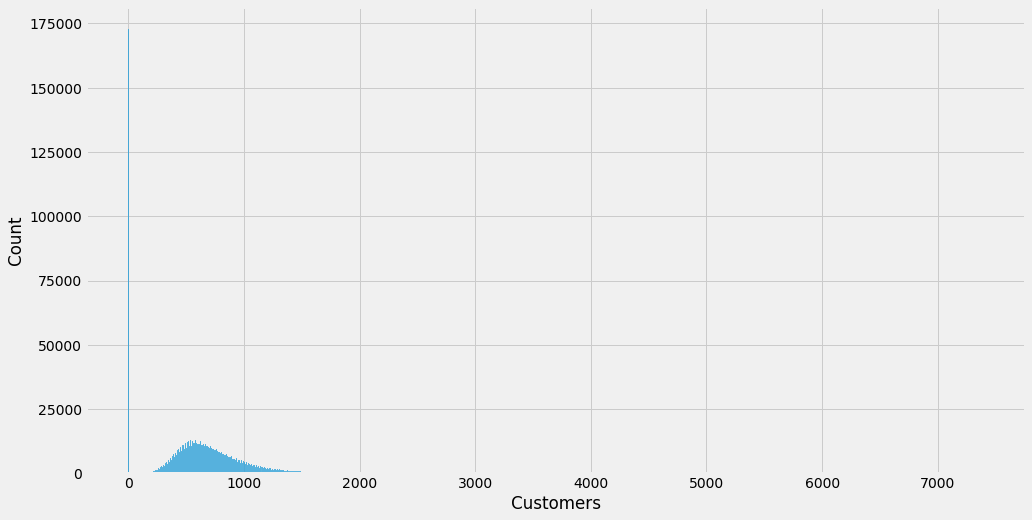

In [13]:
sns.histplot(x = df['Customers'])

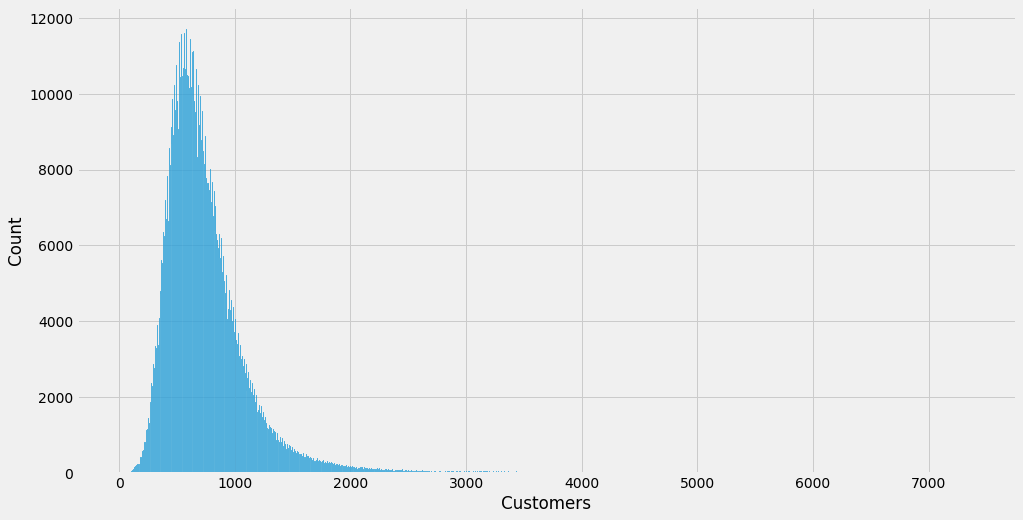

In [14]:
sns.histplot(x = df[df['Customers'] > 0]['Customers'])

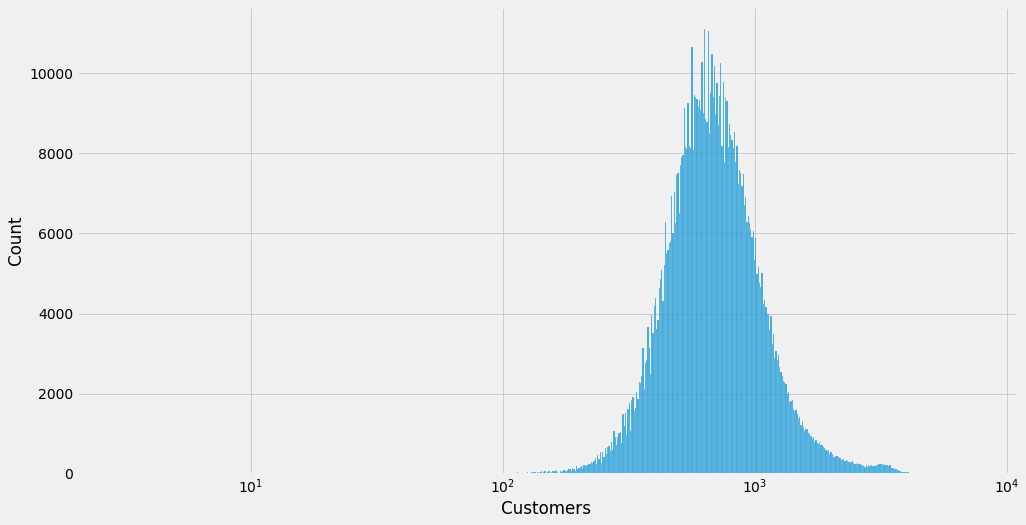

In [15]:
sns.histplot(x = df[df['Customers'] > 0]['Customers'], log_scale = True)

In [16]:
print(df[df['Customers'] > 0]['Customers'].describe())
print('-----------------------------------------')
print(df[df['Customers'] > 0]['Customers'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))

count    844340.000000
mean        762.775369
std         401.195377
min           3.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64
-----------------------------------------
count    844340.000000
mean        762.775369
std         401.195377
min           3.000000
12.5%       431.000000
25%         519.000000
50%         676.000000
75%         893.000000
87.5%      1104.000000
max        7388.000000
Name: Customers, dtype: float64


**3. Open**

In [17]:
print(df['Open'].value_counts())
print('-----------------------------------------')
print(df['Open'].value_counts(normalize = True))

1    844392
0    172817
Name: Open, dtype: int64
-----------------------------------------
1    0.830107
0    0.169893
Name: Open, dtype: float64


In [18]:
print(df[df['Open'] == 0]['DayOfWeek'].value_counts(normalize = True).sort_values(ascending = False))
print('--------------------------------------------')
print(df[df['Open'] == 0]['DayOfWeek'].value_counts().sort_values(ascending = False))

7    0.816685
4    0.064814
5    0.041692
1    0.041489
3    0.021578
2    0.009854
6    0.003889
Name: DayOfWeek, dtype: float64
--------------------------------------------
7    141137
4     11201
5      7205
1      7170
3      3729
2      1703
6       672
Name: DayOfWeek, dtype: int64


**4. Promo**

In [19]:
print(df['Promo'].value_counts())
print('-----------------------------------------')
print(df['Promo'].value_counts(normalize = True))

0    629129
1    388080
Name: Promo, dtype: int64
-----------------------------------------
0    0.618485
1    0.381515
Name: Promo, dtype: float64


In [20]:
print(df[df['Promo'] == 1]['DayOfWeek'].value_counts(normalize = True).sort_values(ascending = False))
print('--------------------------------------------')
print(df[df['Promo'] == 1]['DayOfWeek'].value_counts().sort_values(ascending = False))

1    0.200371
5    0.199907
4    0.199907
3    0.199907
2    0.199907
Name: DayOfWeek, dtype: float64
--------------------------------------------
1    77760
5    77580
4    77580
3    77580
2    77580
Name: DayOfWeek, dtype: int64


**5. State Holiday**

In [21]:
print(df['StateHoliday'].value_counts())
print('-----------------------------------------')
print(df['StateHoliday'].value_counts(normalize = True))

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64
-----------------------------------------
0    0.969475
a    0.019917
b    0.006577
c    0.004031
Name: StateHoliday, dtype: float64


**6. School Holiday**

In [22]:
print(df['SchoolHoliday'].value_counts())
print('-----------------------------------------')
print(df['SchoolHoliday'].value_counts(normalize = True))

0    835488
1    181721
Name: SchoolHoliday, dtype: int64
-----------------------------------------
0    0.821353
1    0.178647
Name: SchoolHoliday, dtype: float64


**7. Sales**

In [23]:
print(df['Sales'].describe())
print('-----------------------------------------')
print(df['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64
-----------------------------------------
count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
12.5%    0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
87.5%    9.707000e+03
max      4.155100e+04
Name: Sales, dtype: float64


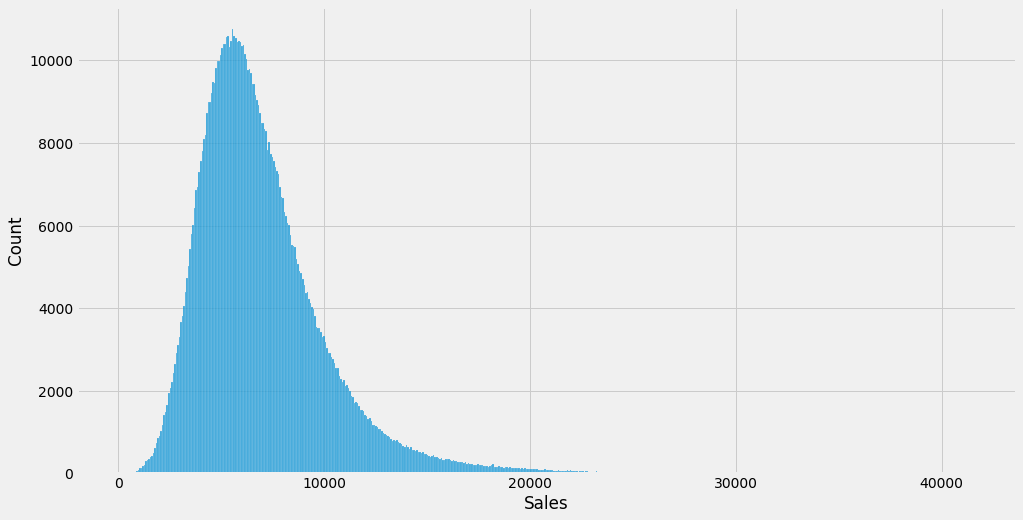

In [24]:
sns.histplot(x = df[df['Sales'] > 0]['Sales'])

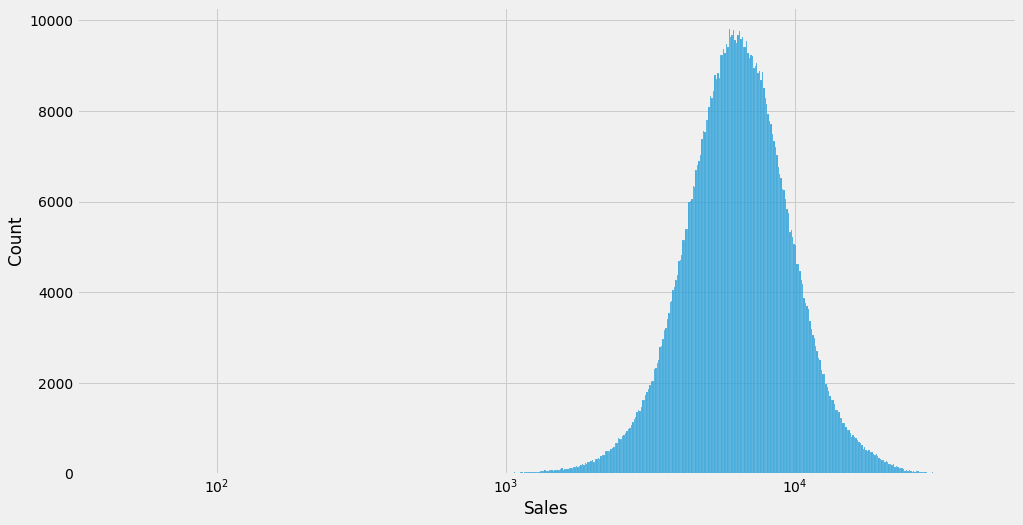

In [25]:
sns.histplot(x = df[df['Sales'] > 0]['Sales'], log_scale = True)

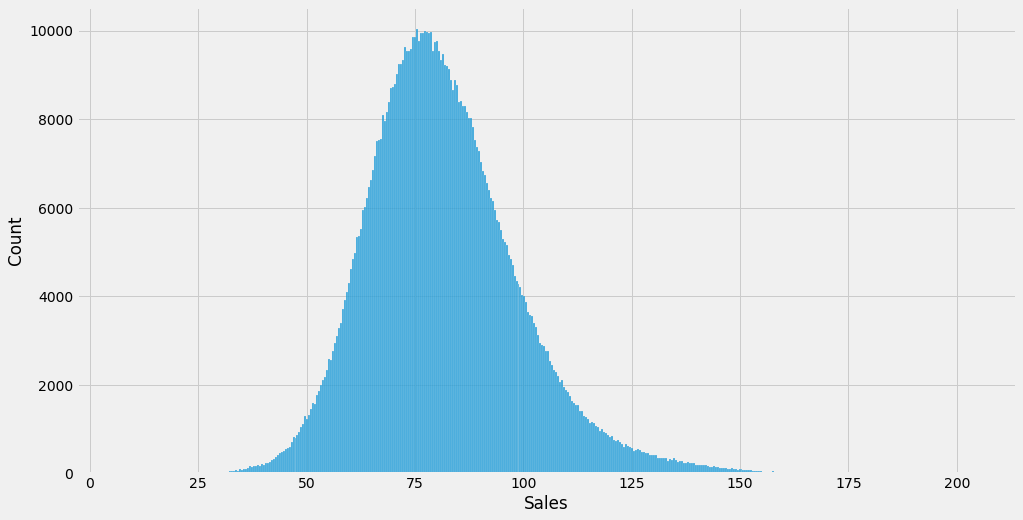

In [26]:
sns.histplot(x = np.sqrt(df[df['Sales'] > 0]['Sales']))

***Bivariate Analysis***

**1. Customers vs Sales**

Text(0, 0.5, 'Sales')

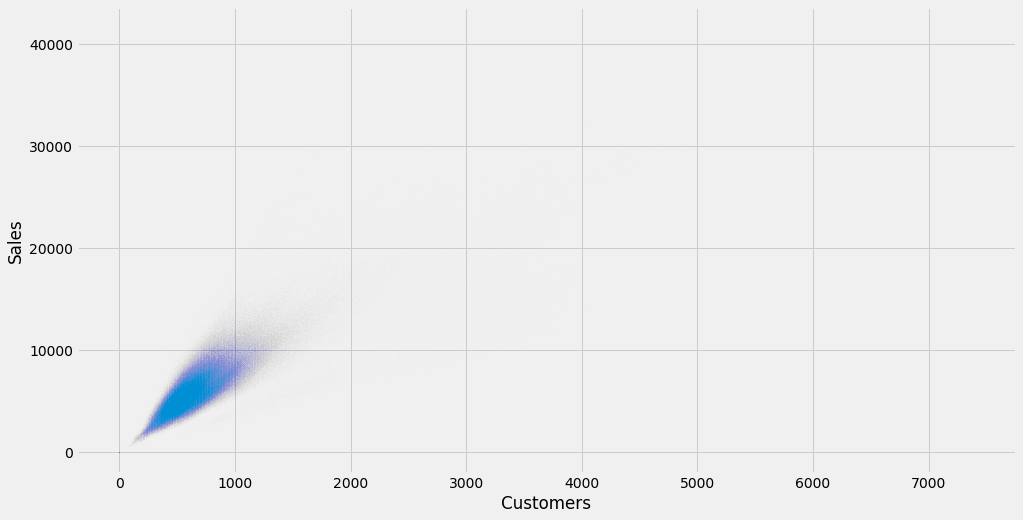

In [27]:
plt.plot(df['Customers'], df['Sales'], 'o', alpha = 0.01, markersize = 0.08)
plt.xlabel("Customers")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

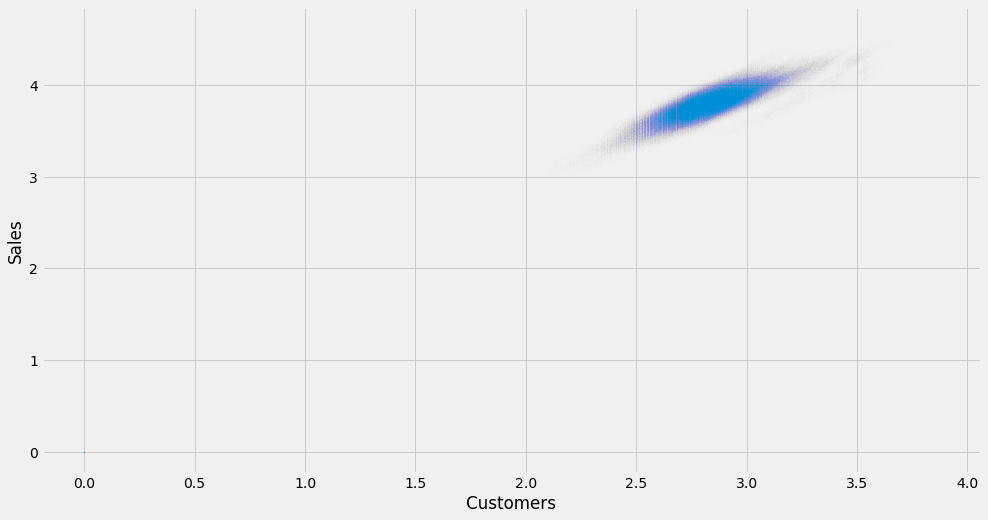

In [28]:
plt.plot(np.log10(df['Customers'] + 1), np.log10(df['Sales'] + 1), 'o', alpha = 0.01, markersize = 0.08)
plt.xlabel("Customers")
plt.ylabel("Sales")

In [29]:
def regression_analysis(x, y):
  reg = LinearRegression()
  reg.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
  preds = reg.predict(x.values.reshape(-1, 1))
  return preds, reg.coef_, reg.intercept_ 

def residual_analysis(x, y):
  x, y = x.values.reshape(-1, 1), y.values.reshape(-1, 1)
  reg = LinearRegression()
  reg.fit(x, y)
  preds = reg.predict(x)
  m, c = reg.coef_, reg.intercept_
  res = y - preds
  return res, preds

Text(0, 0.5, 'Sales')

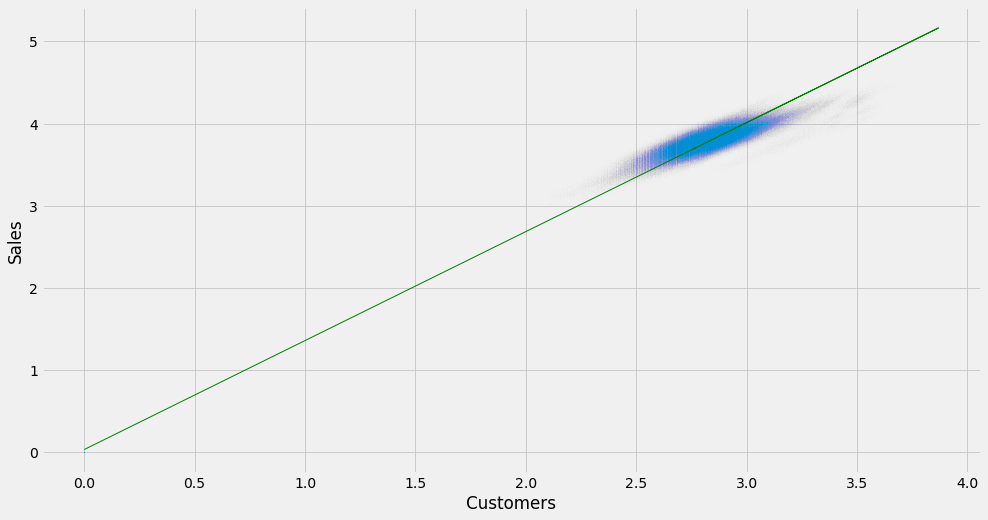

In [30]:
preds, m, c = regression_analysis(x = np.log10(df['Customers'] + 1), y = np.log10(df['Sales'] + 1))

plt.plot(np.log10(df['Customers'] + 1), np.log10(df['Sales'] + 1), 'o', alpha = 0.01, markersize = 0.08)
plt.plot(np.log10(df['Customers'] + 1), preds, color = 'green', lw = 1)
plt.xlabel("Customers")
plt.ylabel("Sales")

In [31]:
print('With a unit increase in the log of customers, the log sales increase by: {}'.format(m))
print('With a 100 fold increase in customers, the sales increase by: {}'.format(10 ** (m + 1)))

With a unit increase in the log of customers, the log sales increase by: [[1.32669878]]
With a 100 fold increase in customers, the sales increase by: [[212.17722994]]


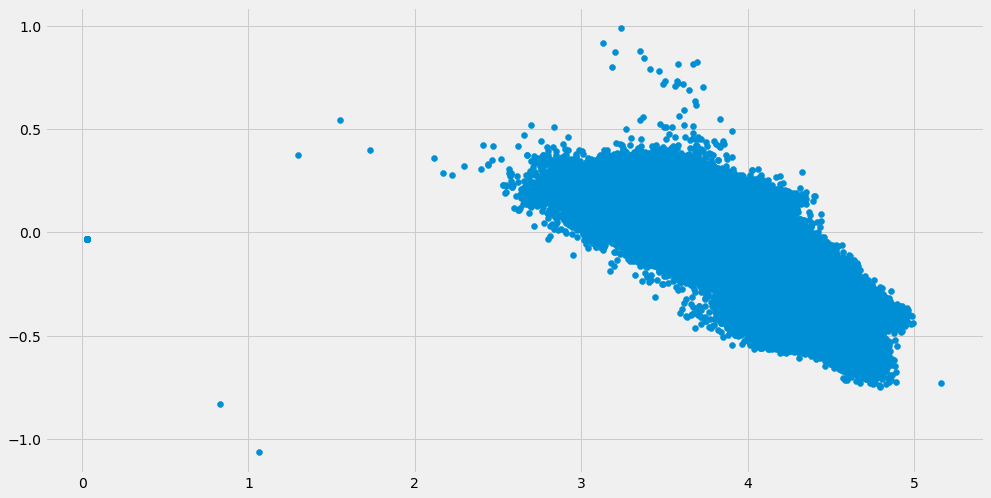

In [32]:
res, preds = residual_analysis(x = np.log10(df['Customers'] + 1), 
                               y = np.log10(df['Sales'] + 1))
plt.scatter(preds, res)

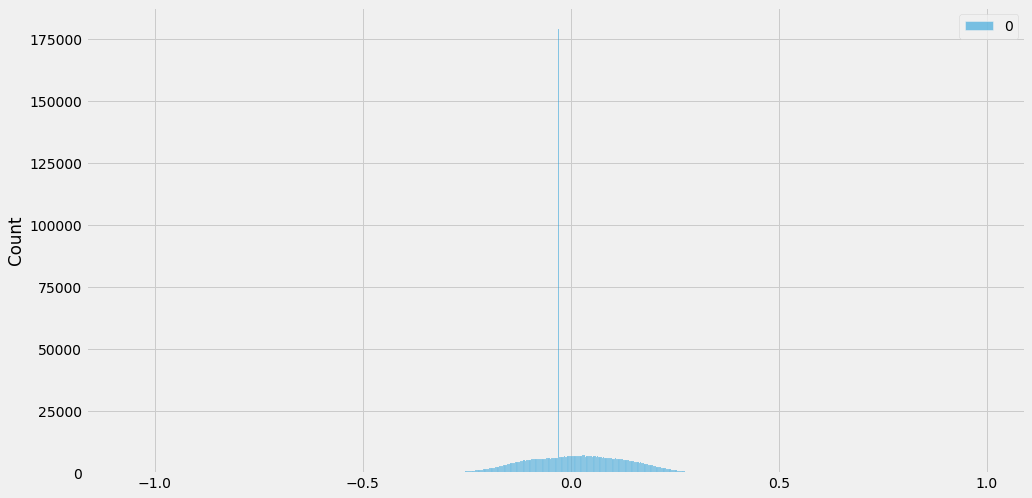

In [33]:
sns.histplot(res)

In [34]:
preds, m, c = regression_analysis(x = df['Customers'], y = df['Sales'])
print(m)

[[7.41706157]]


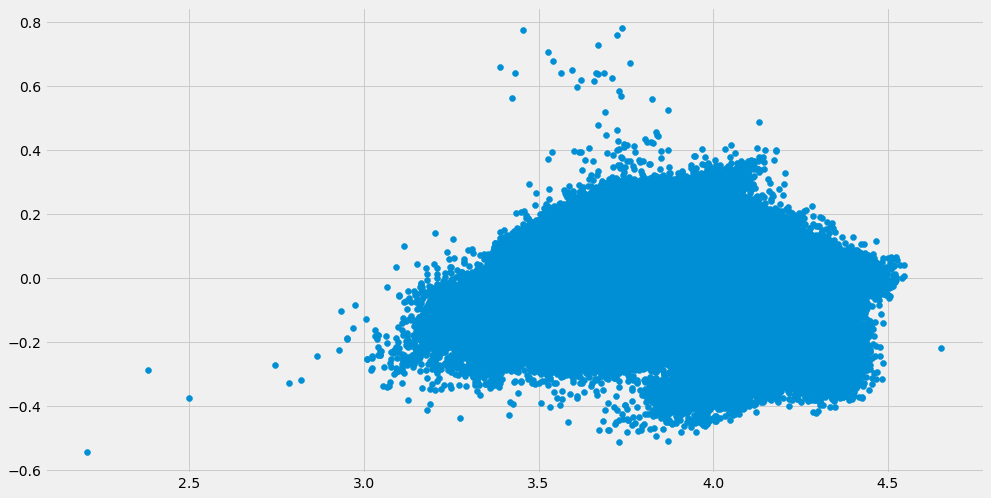

In [35]:
res, preds = residual_analysis(x = np.log10(df[df['Sales'] > 0]['Customers']), 
                               y = np.log10(df[df['Sales'] > 0]['Sales']))
plt.scatter(preds, res)

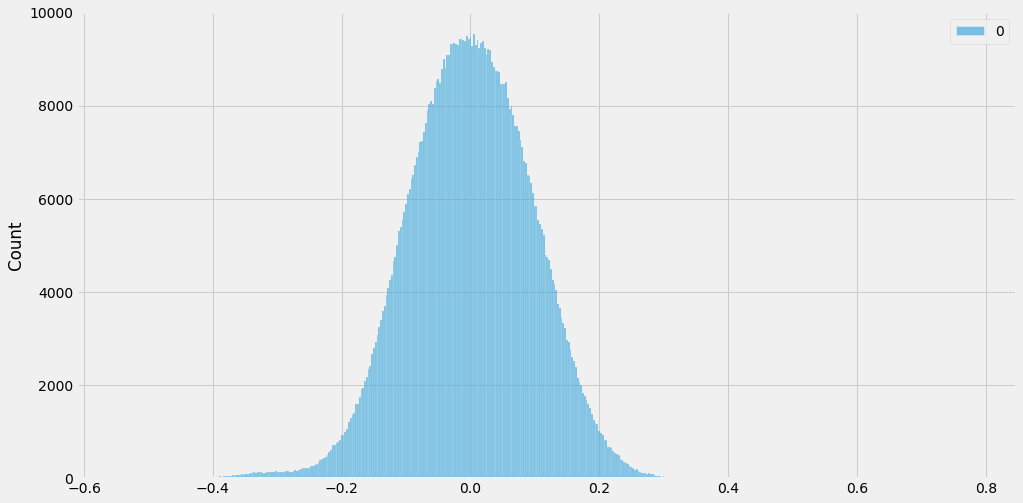

In [36]:
sns.histplot(res)

In [37]:
preds, m, c = regression_analysis(x = np.log10(df[df['Sales'] > 0]['Customers']), 
                                  y = np.log10(df[df['Sales'] > 0]['Sales']))

print('With a unit increase in the log of customers, the log sales increase by: {}'.format(m))
print('With a 100 fold increase in customers, the sales increase by: {}'.format(10 ** (m + 1)))

With a unit increase in the log of customers, the log sales increase by: [[0.8246801]]
With a 100 fold increase in customers, the sales increase by: [[66.78517947]]


In [38]:
## Function to find the CIs for the parameters (slope)

def Simulation(predictor, target, n = 1000, m = 1000):

  slopes = []
  intercepts = []

  data = pd.DataFrame({'x': predictor,
                       'y': target})
  
  for _ in range(m):
    sample = data.sample(n, replace = True)
    preds, beta, c = regression_analysis(sample['x'], sample['y'])

    slopes.append(beta)
    intercepts.append(c)

  ci_slopes = [np.percentile(slopes, 25), np.percentile(slopes, 75)]
  ci_intercepts = [np.percentile(intercepts, 25), np.percentile(intercepts, 75)]

  return ci_slopes, ci_intercepts

In [39]:
predictor = np.log10(df[df['Sales'] > 0]['Customers'])
target = np.log10(df[df['Sales'] > 0]['Sales'])

CI_slopes, CI_intercepts = Simulation(predictor, target)
print(CI_slopes)
print(CI_intercepts)

[0.8130175124344631, 0.8361767435183305]
[1.4304878489464503, 1.4966156367653265]


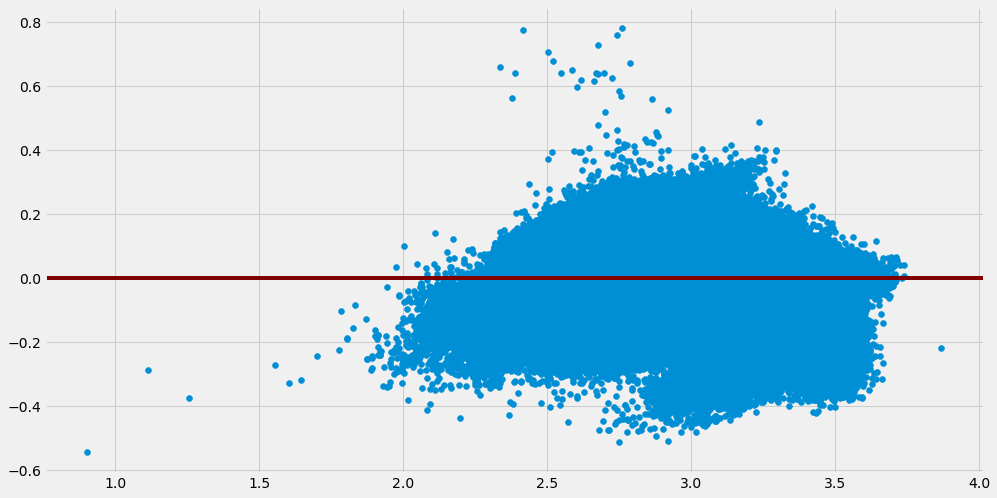

In [40]:
plt.scatter(np.log10(df[df['Sales'] > 0]['Customers']), res)
plt.axhline(y = 0.0, color = 'maroon')

In [41]:
df[(df['Customers'] == 0) & (df['Sales'] > 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


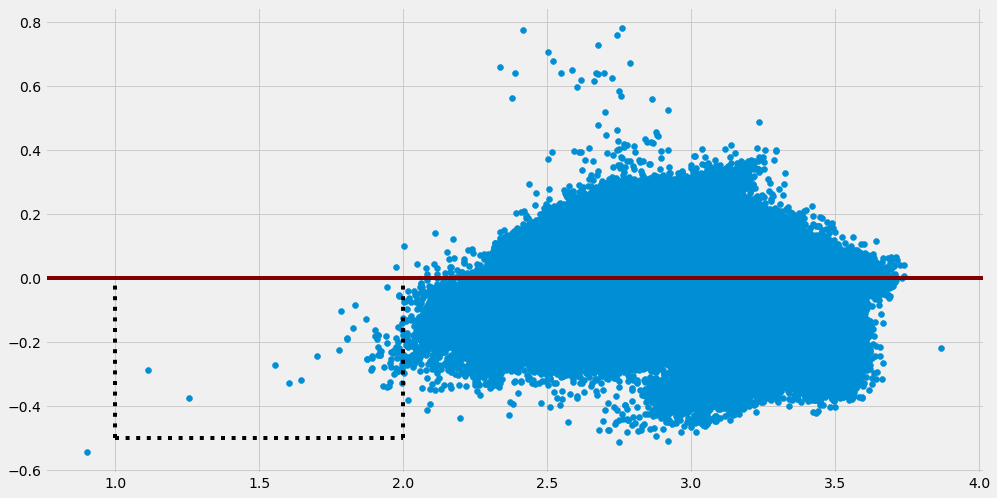

In [42]:
plt.scatter(np.log10(df[df['Sales'] > 0]['Customers']), res)
plt.axhline(y = 0.0, color = 'maroon')

plt.vlines(x = 1.0, ymin = -0.5, ymax = 0.0, ls = ':')
plt.vlines(x = 2.0, ymin = -0.5, ymax = 0.0, ls = ':')
plt.hlines(y = -0.5, xmin = 1.0, xmax = 2.0, ls = ':')

When plotted the log values for the customers against the residuals, it becomes apparent that when the customers are in the range 1 to 2; the residuals are overwhelmingly between -0.1 to -0.5. 1 and 2 on log scale will correspond to 10 to 100 raw customers. And the corresponding log value for the residuals demonstrate that *when the customers are in the range of 10 to 100, the sales are off by around 21% to 69%.*

The rectangular region highlights that proportion.

(-0.6, 0.7)

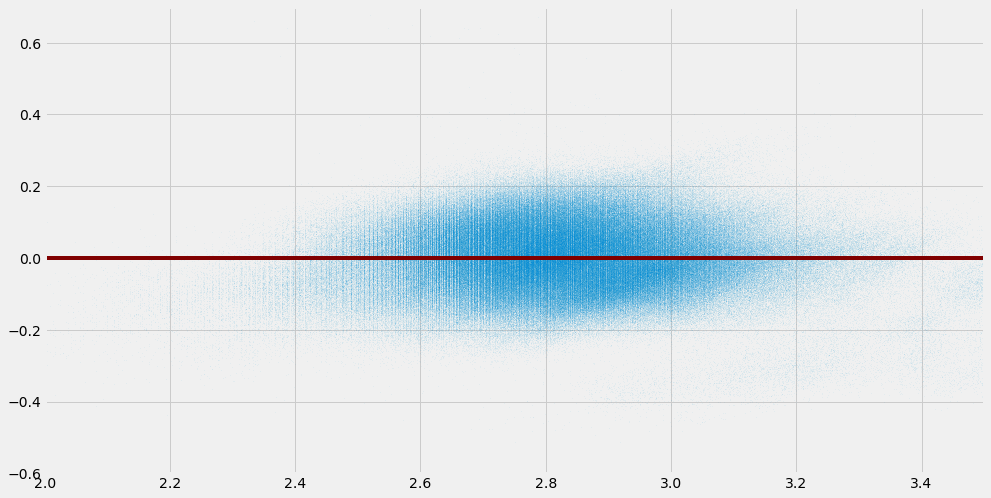

In [43]:
plt.scatter(np.log10(df[df['Sales'] > 0]['Customers']), res, s = 0.001)
plt.axhline(y = 0.0, color = 'maroon')
plt.xlim([2.0, 3.5])
plt.ylim([-0.6, 0.7])

A glance at the middle portion of the plot shows that when the no. of customers are in the range of 150 to 2500, the residuals are evenly distributed on either side of zero (The mean of residuals).

The apparent vertical lines appear because of the discrete nature of the data. Of course, one expects the no. of customers to be count of whole nos. not real nos.

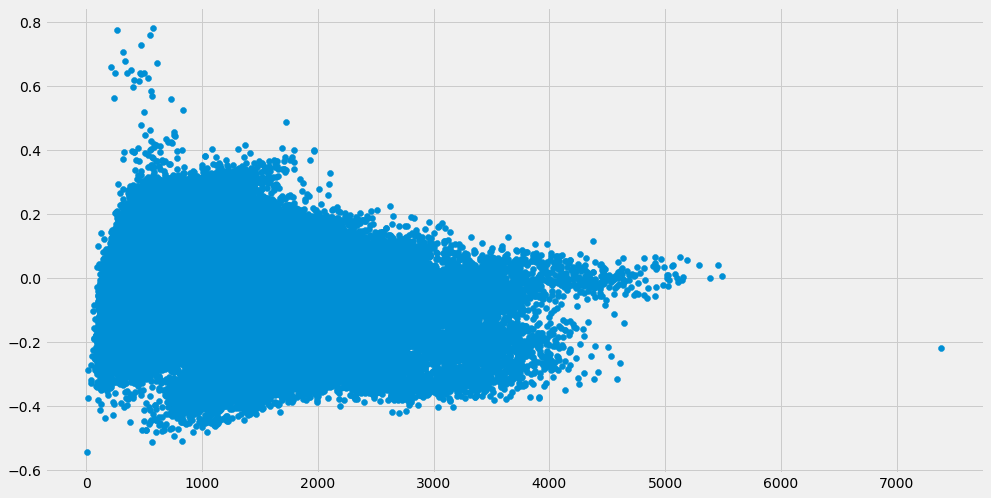

In [44]:
plt.scatter(df[df['Sales'] > 0]['Customers'], res)

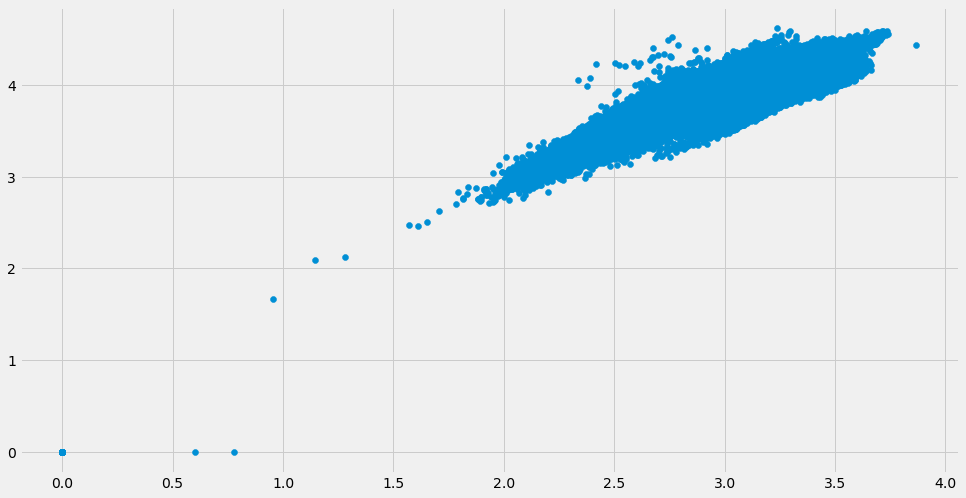

In [45]:
plt.scatter(np.log10(df['Customers'] + 1), np.log10(df['Sales'] + 1))

**2. Promo vs Sales**

Promo is a categorical variable having 2 categories - 0 and 1. So, it requires a different kind of analysis with the "Sales" variable than that of its former counterpart.

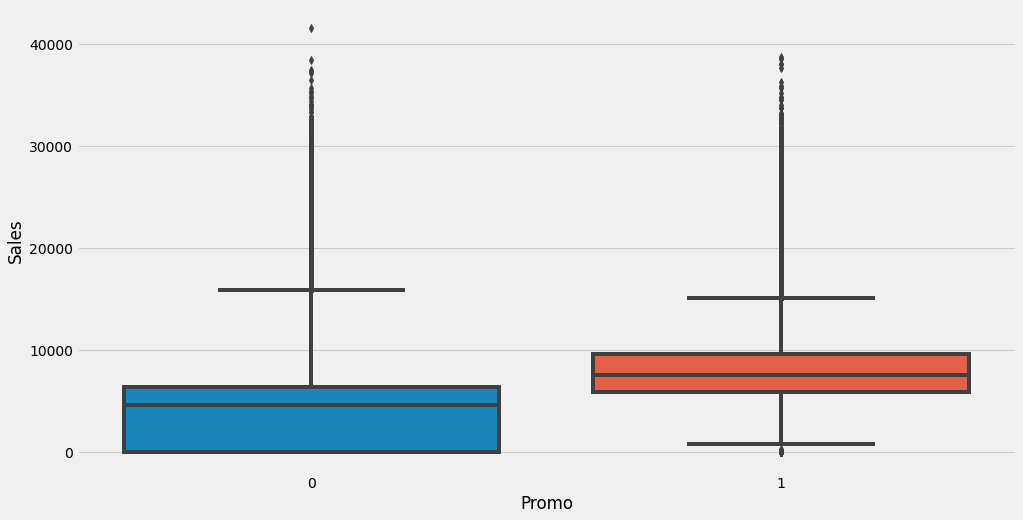

In [46]:
sns.boxplot(x = 'Promo', y = 'Sales', data = df)

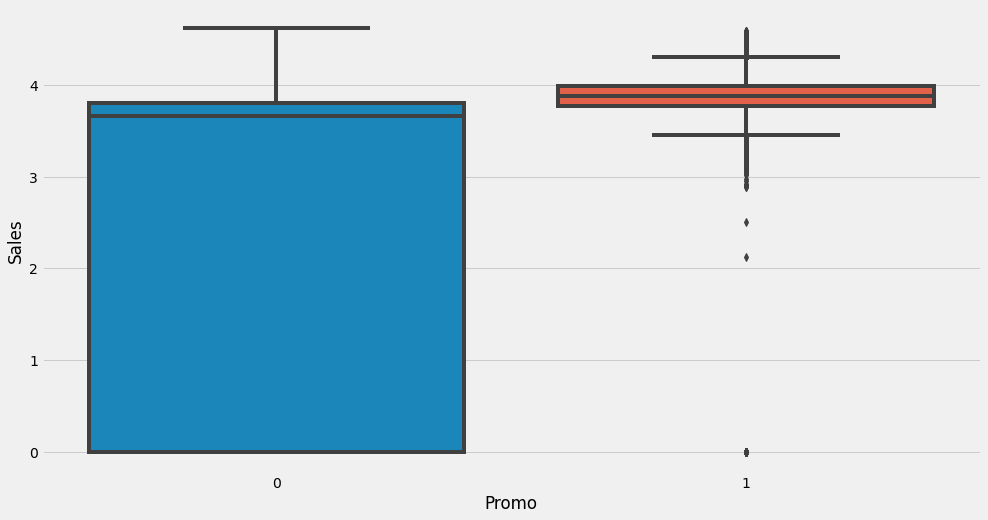

In [47]:
sns.boxplot(x = df['Promo'], y = np.log10(df['Sales'] + 1))

In [48]:
M1 = np.log10(df[(df['Promo'] == 0) & (df['Sales'] > 0)]['Sales'].median())
M2 = np.log10(df[(df['Promo'] == 1) & (df['Sales'] > 0)]['Sales'].median())

iqr1 = np.log10(df[(df['Promo'] == 0) & (df['Sales'] > 0)]['Sales'].quantile(0.75) - df[(df['Promo'] == 0) & (df['Sales'] > 0)]['Sales'].quantile(0.25))
iqr2 = np.log10(df[(df['Promo'] == 1) & (df['Sales'] > 0)]['Sales'].quantile(0.75) - df[(df['Promo'] == 1) & (df['Sales'] > 0)]['Sales'].quantile(0.25))

print(M1)
print(iqr1)
print('------------------------------------------------------')
print(M2)
print(iqr2)
print('------------------------------------------------------')
print(abs(iqr2 - iqr1) / abs(M2 - M1))

3.737113094305961
3.4412236742426123
------------------------------------------------------
3.8836614351536176
3.5582284218033258
------------------------------------------------------
0.7984037682306149


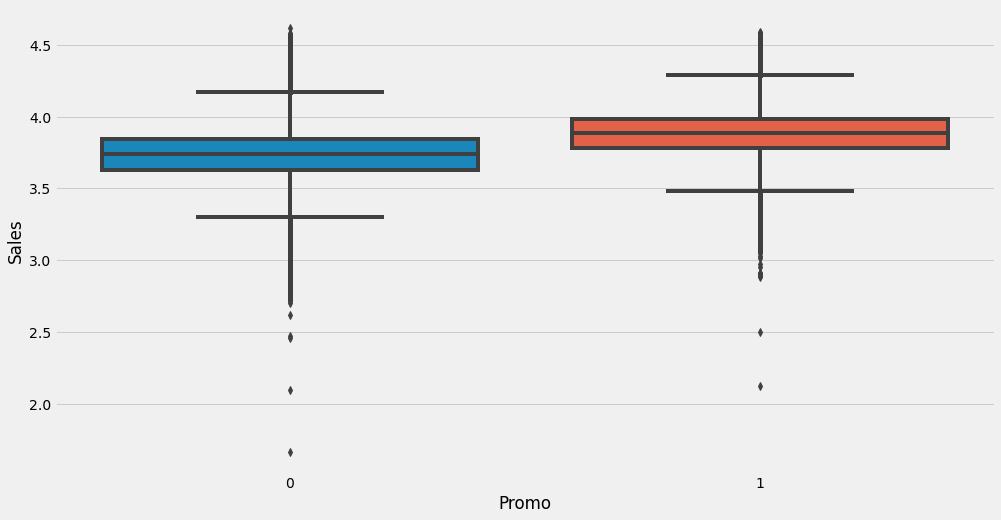

In [49]:
sns.boxplot(x = df[df['Sales'] > 0]['Promo'], y = np.log10(df[df['Sales'] > 0]['Sales']))

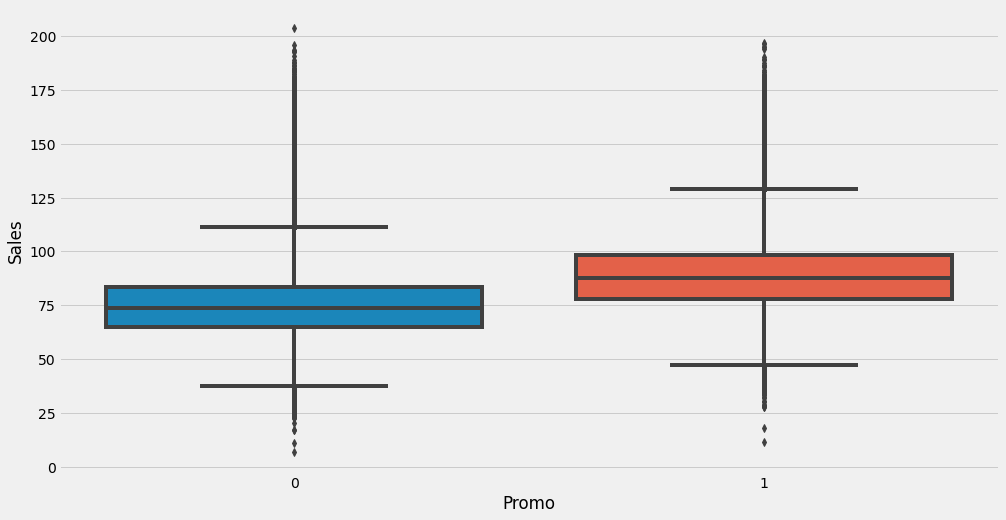

In [50]:
sns.boxplot(x = df[df['Sales'] > 0]['Promo'], y = np.sqrt(df[df['Sales'] > 0]['Sales']))

In [51]:
print(df[(df['Promo'] == 0) & (df['Sales'] > 0)]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))
print('----------------------------------------------------------------')
print(df[(df['Promo'] == 1) & (df['Sales'] > 0)]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))

count    467463.000000
mean       5929.826183
std        2629.269229
min          46.000000
12.5%      3507.000000
25%        4242.000000
50%        5459.000000
75%        7004.000000
87.5%      8466.000000
max       41551.000000
Name: Sales, dtype: float64
----------------------------------------------------------------
count    376875.000000
mean       8228.739731
std        3175.253594
min         133.000000
12.5%      5158.000000
25%        6070.000000
50%        7650.000000
75%        9686.000000
87.5%     11528.000000
max       38722.000000
Name: Sales, dtype: float64


In [52]:
df[(df['Promo'] == 0) & (df['Sales'] == 41551.000000)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
44393,909,1,2015-06-22,41551,1721,1,0,0,0


The corresponding observations in the other variables - especially customers - when the no. of sales is 41551 suggest that this might be a potential outlier. As, one may expect - from the previous analysis - an estimated sales of not more than 12K or 13K for 1721 customers. However, not being much sure about this assumption, I keep the record in the dataset.

**3. Day of Week vs Sales**

In [53]:
## From hereon, we'll almost always deal with the 
## records where the no. of sales is greater than 
## zero. So, let's make a variable for the same

df1 = df[df['Sales'] > 0].copy()

In [54]:
print(df1[['DayOfWeek', 'Sales']].groupby(['DayOfWeek'])['Sales'].count())
print('--------------------------')
print(df1[['DayOfWeek', 'Sales']].groupby(['DayOfWeek'])['Sales'].mean())
print('--------------------------')
print(df1[['DayOfWeek', 'Sales']].groupby(['DayOfWeek'])['Sales'].median())

DayOfWeek
1    137557
2    143955
3    141922
4    134626
5    138633
6    144052
7      3593
Name: Sales, dtype: int64
--------------------------
DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64
--------------------------
DayOfWeek
1    7539.0
2    6502.0
3    6210.0
4    6246.0
5    6581.0
6    5425.0
7    6876.0
Name: Sales, dtype: float64


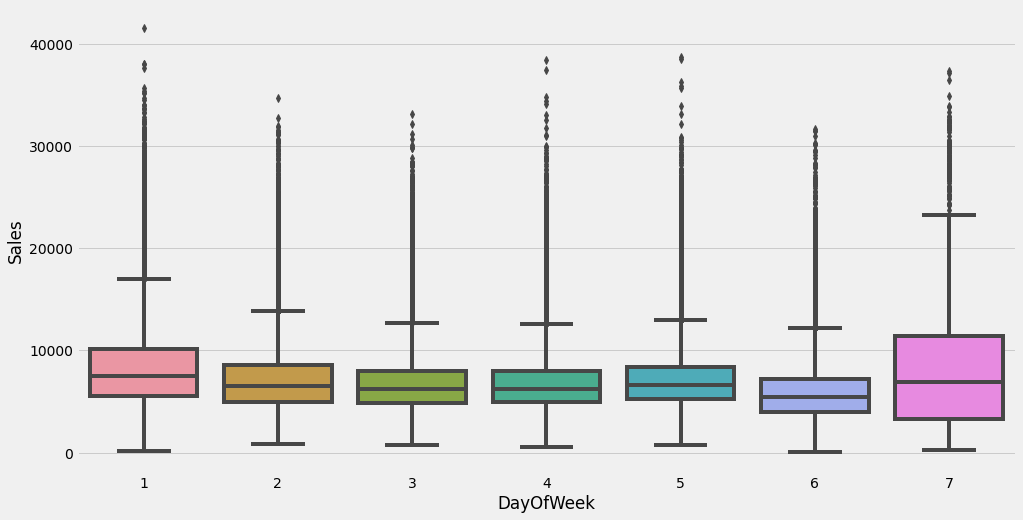

In [55]:
sns.boxplot(x = df[df['Sales'] > 0]['DayOfWeek'], y = df[df['Sales'] > 0]['Sales'])

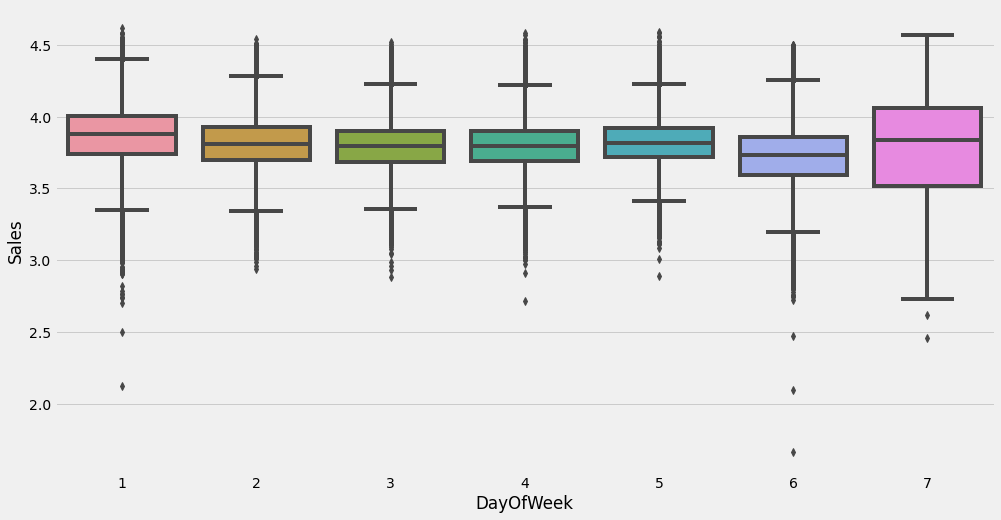

In [56]:
sns.boxplot(x = df[df['Sales'] > 0]['DayOfWeek'], y = np.log10(df[df['Sales'] > 0]['Sales']))

The sales on Mondays appears to outnumber the corresponding figures for Tuesday through Saturday. There's a sudden increase for Friday but the numbers for Saturday is disappointing. The sales figures for Sunday is only second to that of Monday which is unprecedented.

**4. Open vs Sales**

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [58]:
df[df['Sales'] > 0]['Open'].value_counts()

1    844338
Name: Open, dtype: int64

Store is always open when the sales is greater than zero. This variable wouldn't matter for making predictions in regression. Nonetheless, it will be useful for the classification model.

**5. State Holiday vs Sales**

In [59]:
print(df1[['StateHoliday', 'Sales']].groupby(['StateHoliday'])['Sales'].count())
print('--------------------------')
print(df1[['StateHoliday', 'Sales']].groupby(['StateHoliday'])['Sales'].mean())
print('--------------------------')
print(df1[['StateHoliday', 'Sales']].groupby(['StateHoliday'])['Sales'].median())

StateHoliday
0    843428
a       694
b       145
c        71
Name: Sales, dtype: int64
--------------------------
StateHoliday
0    6953.960229
a    8487.471182
b    9887.889655
c    9743.746479
Name: Sales, dtype: float64
--------------------------
StateHoliday
0    6368.0
a    7556.0
b    8423.0
c    8397.0
Name: Sales, dtype: float64


In [60]:
df1['StateHoliday'].value_counts(normalize = True)

0    0.998922
a    0.000822
b    0.000172
c    0.000084
Name: StateHoliday, dtype: float64

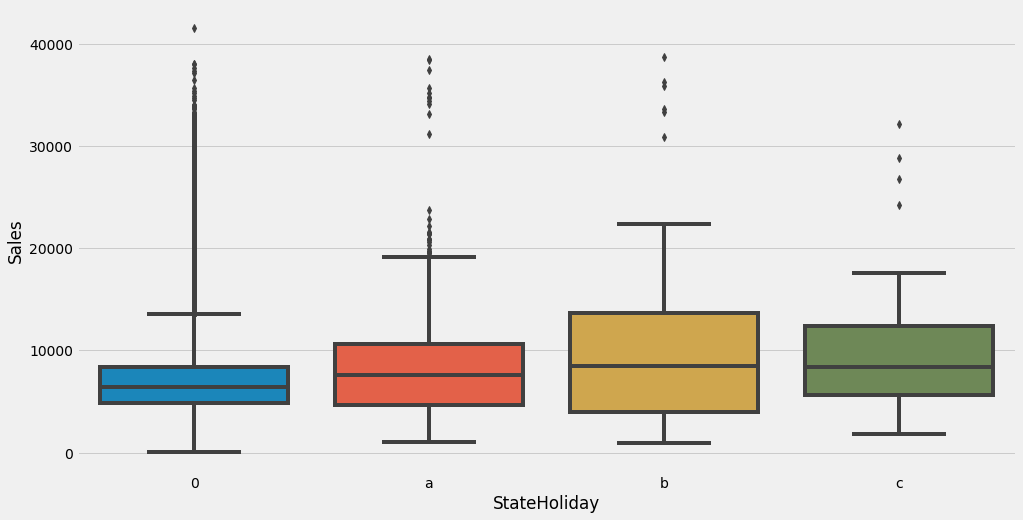

In [61]:
sns.boxplot(x = df1['StateHoliday'], y = df1['Sales'])

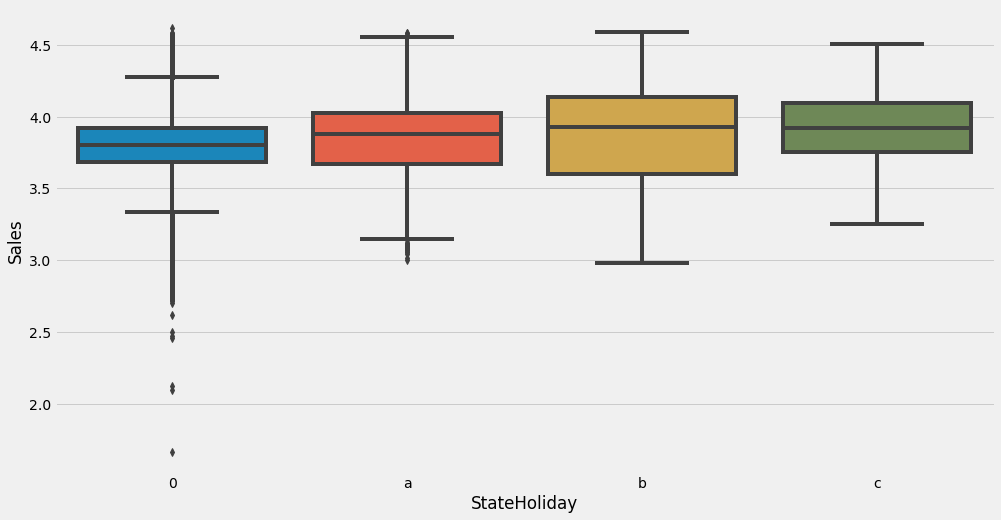

In [62]:
sns.boxplot(x = df1['StateHoliday'], y = np.log10(df1['Sales']))

Apparently, sales is much higher on holidays - especially for type 'b' and 'c' - as compared to when there's no holiday.

**6. School Holiday vs Sales**

In [63]:
print(df1[['SchoolHoliday', 'Sales']].groupby(['SchoolHoliday'])['Sales'].count())
print('--------------------------')
print(df1[['SchoolHoliday', 'Sales']].groupby(['SchoolHoliday'])['Sales'].mean())
print('--------------------------')
print(df1[['SchoolHoliday', 'Sales']].groupby(['SchoolHoliday'])['Sales'].median())

SchoolHoliday
0    680893
1    163445
Name: Sales, dtype: int64
--------------------------
SchoolHoliday
0    6897.207830
1    7200.710282
Name: Sales, dtype: float64
--------------------------
SchoolHoliday
0    6326.0
1    6562.0
Name: Sales, dtype: float64


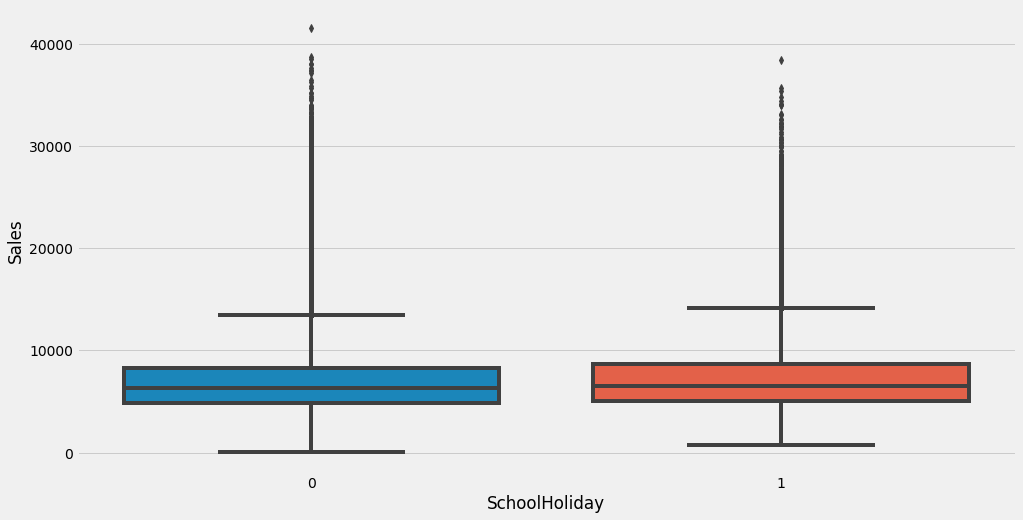

In [64]:
sns.boxplot(x = df1['SchoolHoliday'], y = df1['Sales'])

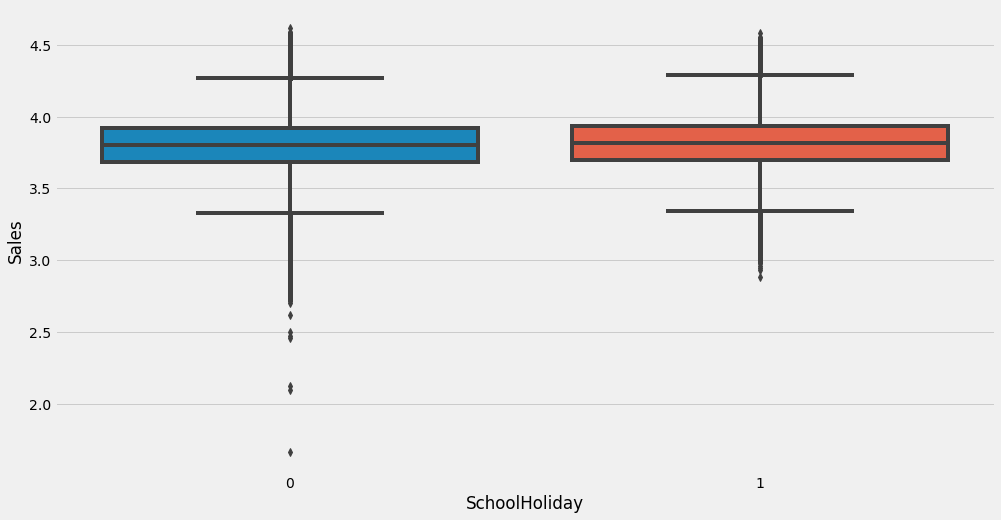

In [65]:
sns.boxplot(x = df1['SchoolHoliday'], y = np.log10(df1['Sales']))

Looks like that the sales are higher when there is a school holiday as compared to the days when there's not. But I would like to look at it more closely. So let's tend to the different quartiles for the data.

In [66]:
print(df1[df1['SchoolHoliday'] == 0]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))
print('----------------------------------------------------------------')
print(df1[df1['SchoolHoliday'] == 1]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]))

count    680893.000000
mean       6897.207830
std        3083.394165
min          46.000000
12.5%      3942.000000
25%        4826.000000
50%        6326.000000
75%        8293.000000
87.5%     10097.000000
max       41551.000000
Name: Sales, dtype: float64
----------------------------------------------------------------
count    163445.000000
mean       7200.710282
std        3175.816988
min         760.000000
12.5%      4146.000000
25%        5004.000000
50%        6562.000000
75%        8648.000000
87.5%     10574.000000
max       38367.000000
Name: Sales, dtype: float64


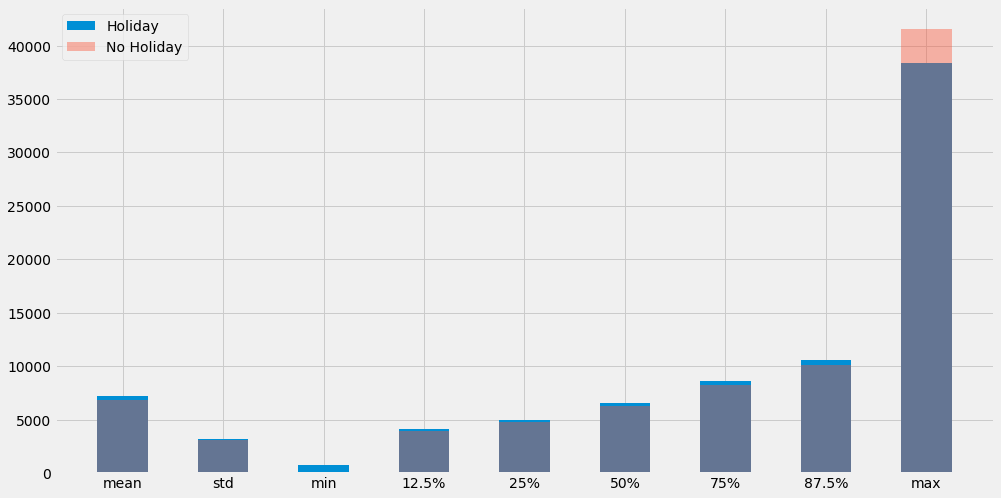

In [67]:
holiday_val = df1[df1['SchoolHoliday'] == 1]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]).values[1:]
holiday_id = df1[df1['SchoolHoliday'] == 1]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]).index[1:]

noholiday_val = df1[df1['SchoolHoliday'] == 0]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]).values[1:]
noholiday_id = df1[df1['SchoolHoliday'] == 0]['Sales'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875]).index[1:]

plt.bar(holiday_id, holiday_val, label = 'Holiday', width = 0.5)
plt.bar(noholiday_id, noholiday_val, label = 'No Holiday', width = 0.5, alpha = 0.4)
plt.legend()
plt.show()

***Let's divert our attention to the 'stores' dataset now***

In [68]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [69]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In order to analyze the data in this dataset, we should merge both the datasets. But let's get some basic idea of the dataset

In [70]:
## The shape of the dataset and the no. of stores that have been referred to

print(stores.shape)
print(stores['Store'].value_counts().sort_values())

(1115, 10)
1       1
10      1
16      1
15      1
14      1
       ..
1102    1
1101    1
1100    1
1106    1
1115    1
Name: Store, Length: 1115, dtype: int64


So each store is referred once.

**1. Store type**

In [71]:
stores['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

Most of the stores are of type 'a', followed by 'd', and 'c'. A few stores are of type 'b' also.

In [72]:
## Distribution of each store in the 'df1' dataset

df1['Store'].value_counts().sort_values(ascending = False)

562    942
769    942
733    942
423    942
85     942
      ... 
909    607
100    606
744    605
348    597
644    592
Name: Store, Length: 1115, dtype: int64

**2. Assortment**

In [73]:
stores['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

Most of the stores have 'basic', and 'extended' assortment. A few have an 'extra' assortment.

**3. Competition distance**

In [74]:
stores['CompetitionDistance'].describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875])

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
12.5%      300.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
87.5%    13576.250000
max      75860.000000
Name: CompetitionDistance, dtype: float64

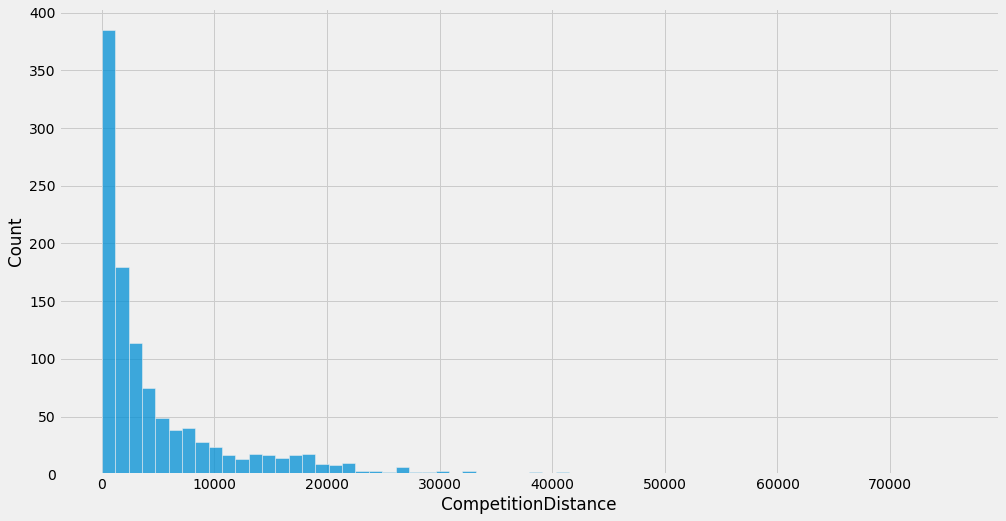

In [75]:
sns.histplot(stores['CompetitionDistance'])

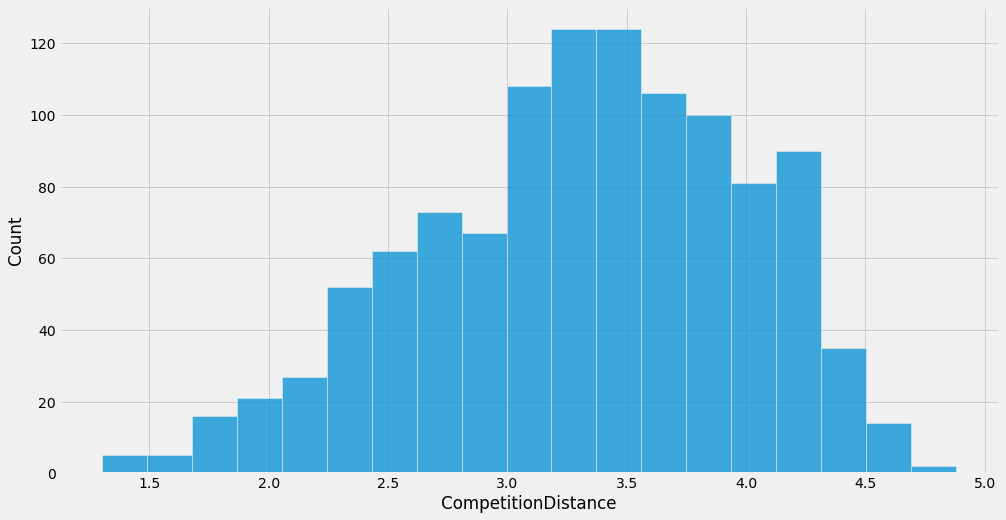

In [76]:
sns.histplot(np.log10(stores['CompetitionDistance']))

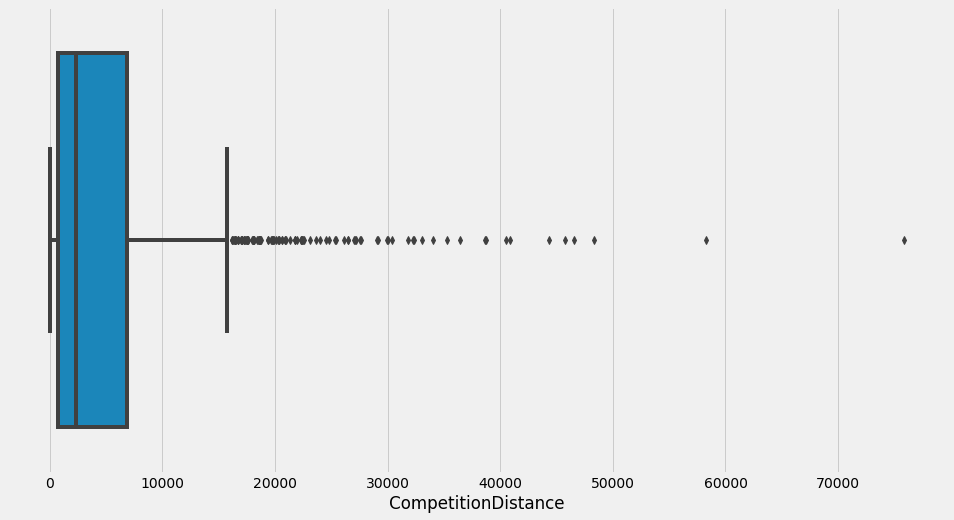

In [77]:
sns.boxplot(x = stores['CompetitionDistance'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


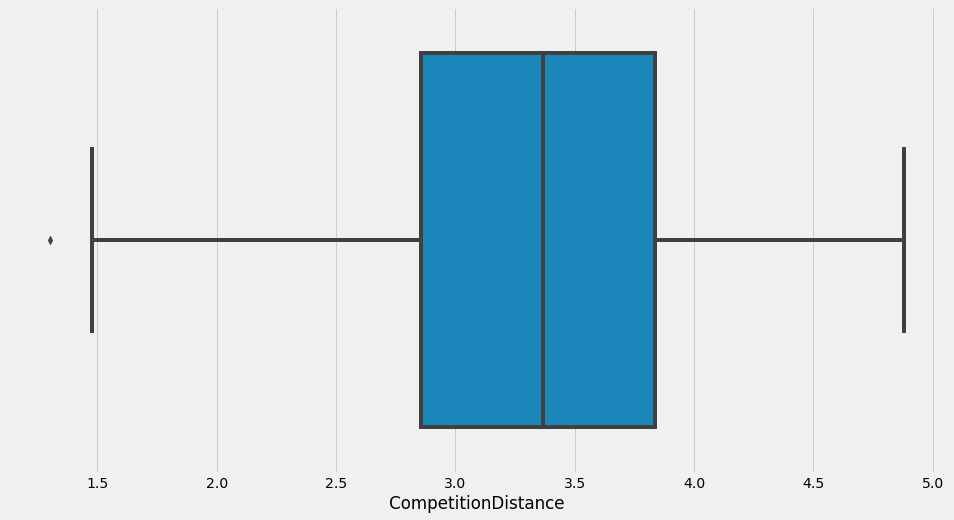

In [78]:
sns.boxplot(np.log10(stores['CompetitionDistance']))

**4. Promo2**

In [79]:
stores['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

**5. Promo2 Since Week**

In [80]:
stores[stores['Promo2SinceWeek'].notna()]['Promo2SinceWeek'].value_counts().sort_index()

1.0     35
5.0     39
6.0      1
9.0     14
10.0    42
13.0    34
14.0    81
18.0    29
22.0    33
23.0     5
26.0     1
27.0    11
28.0     1
31.0    44
35.0    25
36.0    10
37.0    35
39.0     6
40.0    77
44.0     3
45.0    34
48.0     9
49.0     1
50.0     1
Name: Promo2SinceWeek, dtype: int64

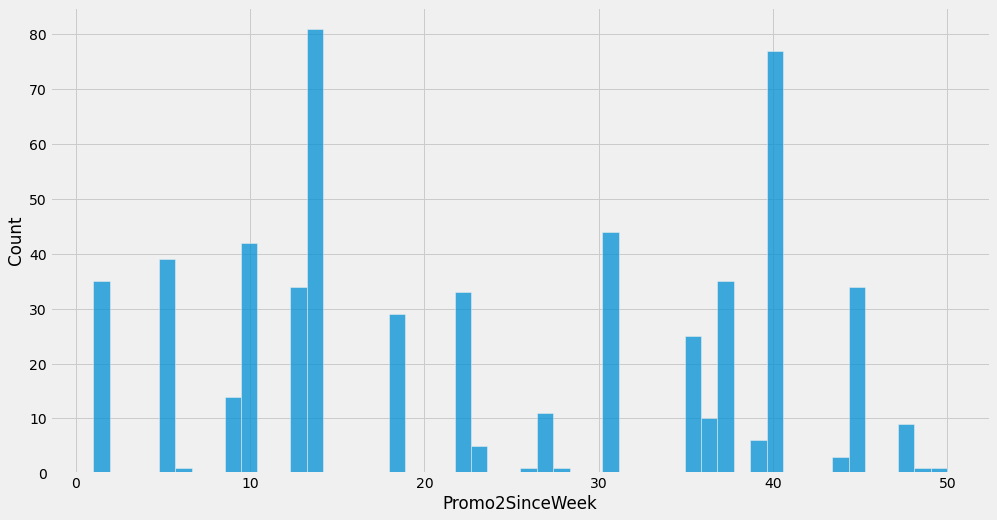

In [81]:
sns.histplot(stores[stores['Promo2SinceWeek'].notna()]['Promo2SinceWeek'], bins = 52)

Apparently most of the 2nd promos begin either in the beginning of each months or towards its end. September seems to be an exception to this trend.

In [82]:
x = stores[stores['Promo2SinceWeek'].notna()]['Promo2SinceWeek']
x.describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875])

count    571.000000
mean      23.595447
std       14.141984
min        1.000000
12.5%      5.000000
25%       13.000000
50%       22.000000
75%       37.000000
87.5%     40.000000
max       50.000000
Name: Promo2SinceWeek, dtype: float64

**6. Promo2 Since Year**

In [83]:
x = stores[stores['Promo2SinceYear'].notna()]['Promo2SinceYear']
x.describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875])

count     571.000000
mean     2011.763573
std         1.674935
min      2009.000000
12.5%    2009.000000
25%      2011.000000
50%      2012.000000
75%      2013.000000
87.5%    2014.000000
max      2015.000000
Name: Promo2SinceYear, dtype: float64

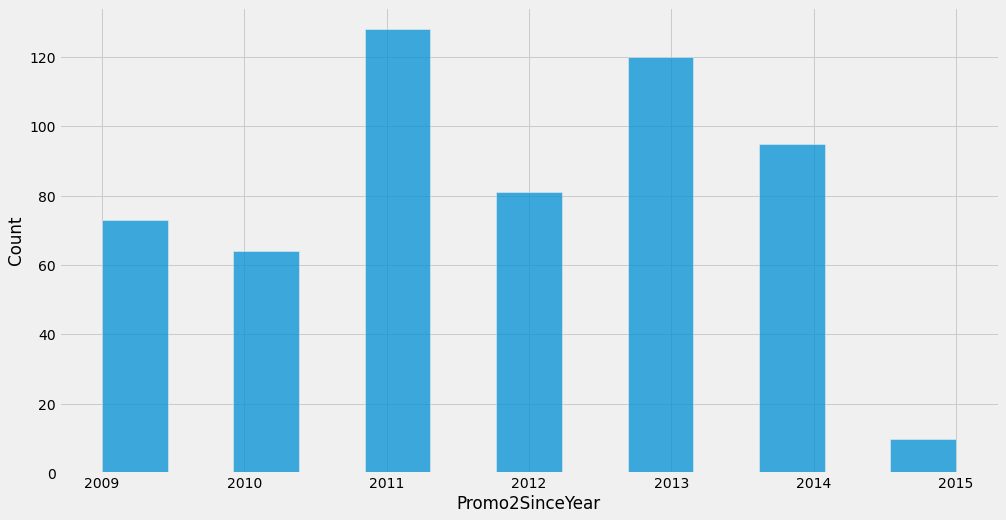

In [84]:
sns.histplot(x)

In [85]:
x.value_counts().sort_index()

2009.0     73
2010.0     64
2011.0    128
2012.0     81
2013.0    120
2014.0     95
2015.0     10
Name: Promo2SinceYear, dtype: int64

50% of the 2nd promos have begun between 2011 and 2013, whereas 75% have started between 2009 and 2014.

**7. Promo interval**

In [86]:
x = stores[stores['PromoInterval'].notna()]['PromoInterval']
x.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

**8. Competition open since month**

In [87]:
x = stores[stores['CompetitionOpenSinceMonth'].notna()]['CompetitionOpenSinceMonth']
x.value_counts().sort_index()

1.0      14
2.0      41
3.0      70
4.0      94
5.0      44
6.0      50
7.0      67
8.0      39
9.0     125
10.0     61
11.0     92
12.0     64
Name: CompetitionOpenSinceMonth, dtype: int64

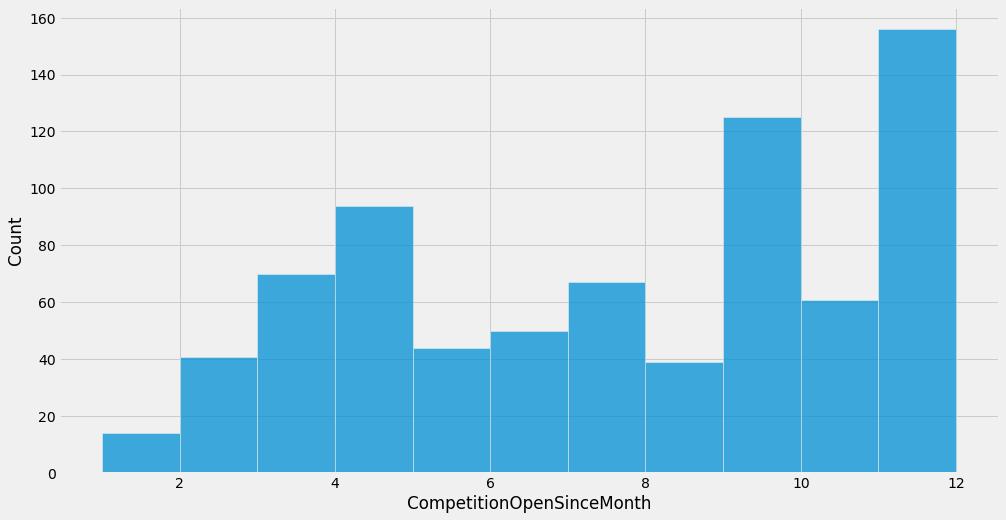

In [88]:
sns.histplot(x)

In [89]:
x.describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875])

count    761.000000
mean       7.224704
std        3.212348
min        1.000000
12.5%      3.000000
25%        4.000000
50%        8.000000
75%       10.000000
87.5%     11.000000
max       12.000000
Name: CompetitionOpenSinceMonth, dtype: float64

On an average, the company may expect the competitors to have been established in the month of July or August.

50% of the competitors came about between April and October.

**9. Competition open since year**

In [90]:
x = stores[stores['CompetitionOpenSinceYear'].notna()]['CompetitionOpenSinceYear']
x.value_counts().sort_index()

1900.0     1
1961.0     1
1990.0     5
1994.0     2
1995.0     2
1998.0     1
1999.0     8
2000.0    10
2001.0    16
2002.0    27
2003.0    19
2004.0    22
2005.0    62
2006.0    47
2007.0    48
2008.0    54
2009.0    54
2010.0    55
2011.0    54
2012.0    82
2013.0    83
2014.0    70
2015.0    38
Name: CompetitionOpenSinceYear, dtype: int64

The first Rossmann store was opened in 1972. However, an observation corresponding to the year 1900 suggests that the data does not pertain to the rossmann stores, but the other retailers.

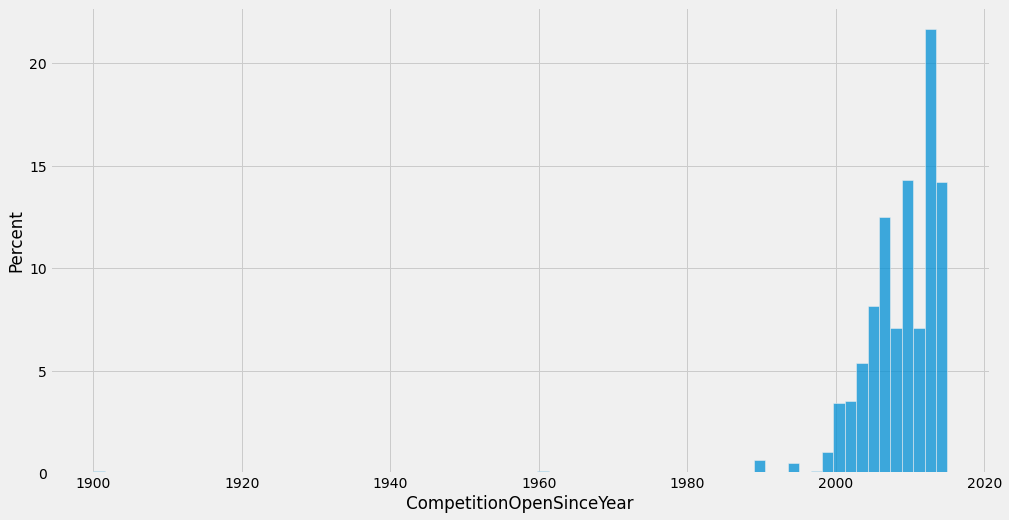

In [91]:
sns.histplot(x, stat = 'percent')

In [92]:
x.describe(percentiles = [0.125, 0.25, 0.5, 0.75, 0.875])

count     761.000000
mean     2008.668857
std         6.195983
min      1900.000000
12.5%    2004.000000
25%      2006.000000
50%      2010.000000
75%      2013.000000
87.5%    2014.000000
max      2015.000000
Name: CompetitionOpenSinceYear, dtype: float64

On an average, the company may expect the competitor to have been established between 2008 and 10. Whereas, 50% of the competitors have come about between 2006 and 14.

***Dealing with the missing observations***

**1. Competition distance**

In [93]:
stores['CompetitionDistance'].max()

75860.0

In [94]:
stores[stores['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


For competitor distance variable, it might have been the case that for the distance might not have been recorded when the competitor was more than 76km away or not within this radius. The table above suggests that the corresponding observations for the competition open month and year too are empty. This further emphasises our claim.

In [95]:
## Let's take 76K for the null values

stores['CompetitionDistance'].fillna(76000, inplace = True)

**2. Competition Open Since Month**

In [96]:
stores['CompetitionOpenSinceMonth'].isna().sum()

354

for as many as 354 stores, the approximate month in which the competitor was established is not known. 



Intuitively, I think that the stores for which the distance from the competitor is greater, effort may not have been made for collecting the year or month since when the competitor have been in operation. Let's find out.

In [97]:
y = stores[stores['CompetitionOpenSinceMonth'].notnull()]['CompetitionDistance']
x = stores[stores['CompetitionOpenSinceMonth'].isnull()]['CompetitionDistance']

print(y.describe())
print('--------------------------------------')
print(x.describe())

count      761.000000
mean      5392.930355
std       7783.215981
min         30.000000
25%        730.000000
50%       2230.000000
75%       6470.000000
max      58260.000000
Name: CompetitionDistance, dtype: float64
--------------------------------------
count      354.000000
mean      6028.898305
std       9816.456159
min         20.000000
25%        647.500000
50%       2560.000000
75%       8012.500000
max      76000.000000
Name: CompetitionDistance, dtype: float64


A simple examination suggests that there is not a substantive difference between the stats of both the categories. Which means that our earlier hypothesis could not be proved.

*What could explain the missingness in this variable?*

I don't think that any variable in this dataset could possibly explain the missingness in the variable in question. Perhaps, the stores, when being established, did not take into account the data of their competitors. I conclude - on my own - that this is the case of *"Missing not at random".* And that - sans an educated method for imputation - this variable should better be removed.

**3. Competition Open Since Year**

In [98]:
stores[(stores['CompetitionOpenSinceMonth'].isnull()) & (stores['CompetitionOpenSinceYear'].isnull())].shape

(354, 10)

Looks like the data for competition open since year is missing for all the records where the competition open since month too is missing.

It makes sense to drop this variable too.

In [99]:
## Dropping both the variables 

stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, inplace = True)

**4. Promo2 since week/year and promo interval**

For these 3 variables, all the variables corresponding to when the promo2 is 0 must be empty. For these variables do not make sense when the corresponding stores are not participating in the consecutive promos in the first place.

For the former to variables (promo since week / year), I'm substituting the nulls with 0s. However for the latter (promo interval), creating a separate category would make more sense.

In [100]:
## Filling nulls with 0s

stores['Promo2SinceWeek'].fillna(0.0, inplace = True)
stores['Promo2SinceYear'].fillna(0.0, inplace = True)

## Filling nulls with 'unk' -
## denoting unknowns

stores['PromoInterval'].fillna('unk', inplace = True)

In [101]:
stores.isna().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Promo2SinceWeek        0
Promo2SinceYear        0
PromoInterval          0
dtype: int64

***Feature engineering in the stores dataset***

The categorical variables should be converted into dummy variables. Why? Because all of them are cardinal, i.e. not ordered.

Also, for the dummies, one category has to be removed - technically allowed to be subsumed by the intercept. Why? Because, I intend to use linear regression model, i.e. a least squares model. When we make dummies for all the categories, the data fosters singularity. Say, for instance, we have 3 categories in a variable. If we make dummies of two of them, the third variable becomes predictable - by using the first two dummies. 

However, we'll do that later. For now, let's keep all the dummies so that it is subservient for us to analyze the data with the sales variable.

In [102]:
stores = pd.get_dummies(stores, columns = ['StoreType', 'Assortment', 'PromoInterval'], 
                        prefix = ['StoreType', 'Assortment', 'PromoInt'])
stores.tail()

,Store,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInt_Feb,May,Aug,Nov","PromoInt_Jan,Apr,Jul,Oct","PromoInt_Mar,Jun,Sept,Dec",PromoInt_unk
1110,1111,1900.0,1,31.0,2013.0,1,0,0,0,1,0,0,0,1,0,0
1111,1112,1880.0,0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,1
1112,1113,9260.0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1
1113,1114,870.0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1
1114,1115,5350.0,1,22.0,2012.0,0,0,0,1,0,0,1,0,0,1,0


Additionally, we should remove the "Promo2" variable. Why? 2 variables - "Promo2SinceWeek", and "Promo2SinceYear" - are nested in it. Both of these nested variables are 0 when the indicator (Promo2) is 0 and are discrete otherwise. The indicator variable in this situation is dependent on the nested variables and thus is exhibiting a linear relationship. 

In [103]:
stores.drop('Promo2', axis = 1, inplace = True)

In [104]:
## rows x columns in the stores dataset now

stores.shape

(1115, 15)

***Merging the datasets together***

Before merging the 2 datasets, we must do some feature engineering on the 'df' dataset.

In [105]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [106]:
## Keep only the records for which the sales is greater than 0
## Remove the 'Open' variable as it is always 1 for when sales > 0

df = df[df['Sales'] > 0]
df.drop('Open', axis = 1, inplace = True)
df.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1
1017190,1097,2,2013-01-01,5961,1405,0,a,1


In [107]:
## Make dummies for the "StateHoliday" 
## and the "DayOfWeek" variable.
## Of course we're considering week days
## as separate categories.

df = pd.get_dummies(df, columns = ['StateHoliday', 'DayOfWeek'], 
                        prefix = ['StateHoliday', 'DayOfWeek'],
                        drop_first = True)
df.tail()

,Store,Date,Sales,Customers,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
1016776,682,2013-01-01,3375,566,0,1,1,0,0,1,0,0,0,0,0
1016827,733,2013-01-01,10765,2377,0,1,1,0,0,1,0,0,0,0,0
1016863,769,2013-01-01,5035,1248,0,1,1,0,0,1,0,0,0,0,0
1017042,948,2013-01-01,4491,1039,0,1,1,0,0,1,0,0,0,0,0
1017190,1097,2013-01-01,5961,1405,0,1,1,0,0,1,0,0,0,0,0


In [108]:
## Extract the months and years from the "Date" variable

df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month'] = df['Date'].apply(lambda x: x.month)

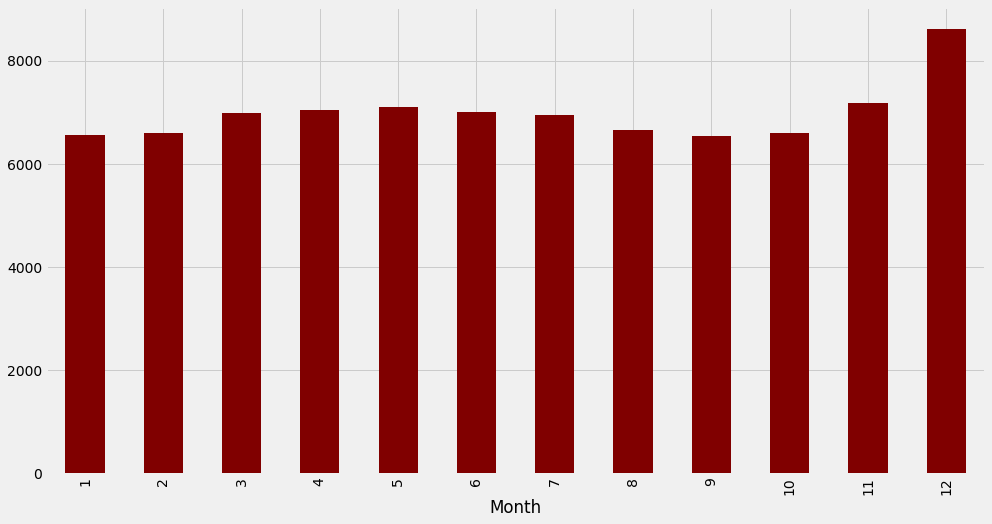

In [109]:
## Analyzing the months against sales

df.groupby(['Month'])['Sales'].mean().plot(kind = 'bar', color = 'maroon')

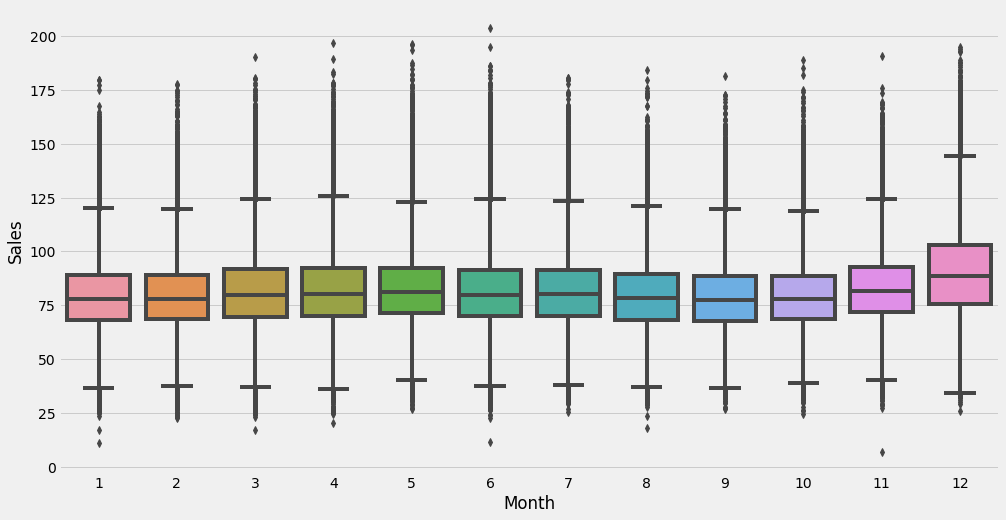

In [110]:
sns.boxplot(x = df['Month'], y = np.sqrt(df['Sales']))

Apparently, the sales increase gradually from the start of the month until May from when it starts decreasing at the same pace making an even steep at the month of May. The sales decrease until October when it is almost at the same level as in January and from then increases at a higher rate until the end of the year when the mean sales cross the 8000 mark.

Fortunately, the data for each month has been given.

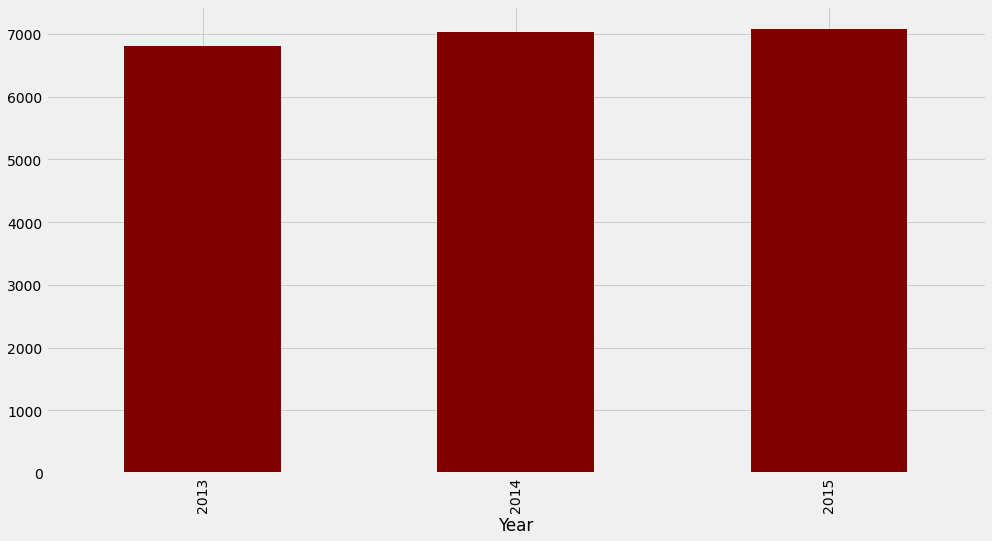

In [111]:
## Analyzing the years against sales

df.groupby(['Year'])['Sales'].mean().plot(kind = 'bar', color = 'maroon')

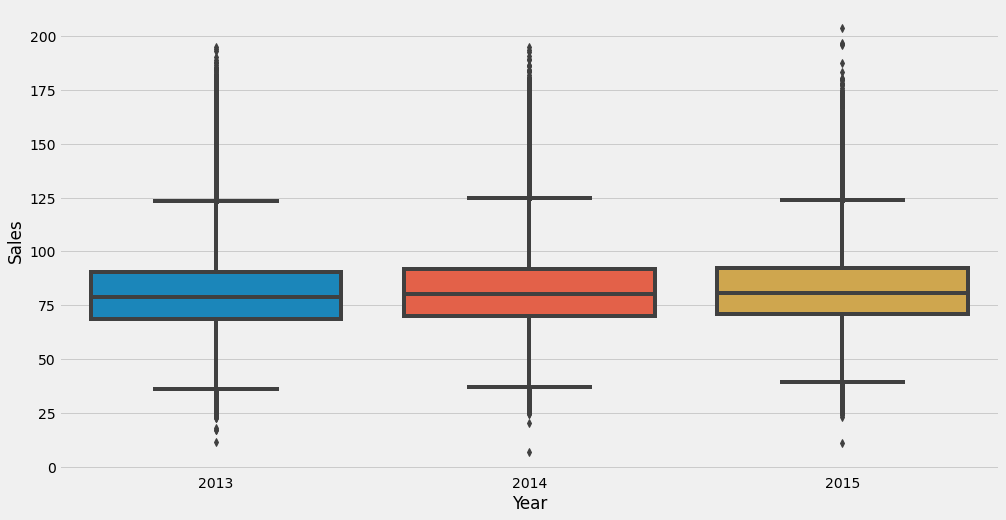

In [112]:
sns.boxplot(x = df['Year'], y = np.sqrt(df['Sales']))

The mean sales has incremented each year, at a higher rate from 2013 to 14 and at a comparatively slower rate from 2014-15.

In [113]:
## Drop the "Date" variable now

df.drop("Date", axis = 1, inplace = True)

***Promotions and Months***

Let's find out the probability of promotions = 0 or 1 given the months. That is, p(promo | month). We'll find for which month is the probability of promoitions is more.

In [114]:
pd.crosstab(df['Promo'], df['Month'])

Month,1,2,3,4,5,6,7,8,9,10,11,12
Promo,,,,,,,,,,,,
0,48039,46903,44846,43868,43987,47212,44563,30945,30021,30885,26301,29893
1,38296,33336,41129,37858,36112,35359,41013,23466,22300,22406,25100,20500


In [115]:
pd.crosstab(df['Promo'], df['Month'], normalize = "columns") * 100

Month,1,2,3,4,5,6,7,8,9,10,11,12
Promo,,,,,,,,,,,,
0,55.642555,58.454118,52.161675,53.67692,54.915792,57.177459,52.07418,56.872691,57.37849,57.955377,51.168265,59.319747
1,44.357445,41.545882,47.838325,46.32308,45.084208,42.822541,47.92582,43.127309,42.62151,42.044623,48.831735,40.680253


The p(promo = 0 | any moth) > p(promo = 1 | any moth). This is in part because a majority, 55% of the data in the dataframe corresponds to promo = 0. Talking specifically about promo = 1 category, it is the higher for the months of March, April, May, July, and November. The probability of no promotion in this months will be lower eventually. Should the company concentrate more on the last quarter - months of September, October, November, and December? Depends on the impact of promotions on the sales.

From previous analysis, it is evident that both the mean and median for sales is more when there's a promotion in place. In fact, the mean sales is higher for the months for which the probability of promotions given conditional on that month is higher as compared to the other months. Looks like promotions have paid off. 

In [116]:
## Merging the two dataframes now

df = pd.merge(df, stores, on = "Store")
df.tail()

,Store,Sales,Customers,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_2,DayOfWeek_3,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInt_Feb,May,Aug,Nov","PromoInt_Jan,Apr,Jul,Oct","PromoInt_Mar,Jun,Sept,Dec",PromoInt_unk
844333,292,9291,1002,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
844334,292,2748,340,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
844335,292,4202,560,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
844336,292,4580,662,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
844337,292,5076,672,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [117]:
df.shape

(844338, 30)

***What if we bin months into quarters?***

The bar graphs above suggest a quarterly trend in the sales. Note that the mean sales for the second and fourth quarter is high whereas for those of the first and third is low.

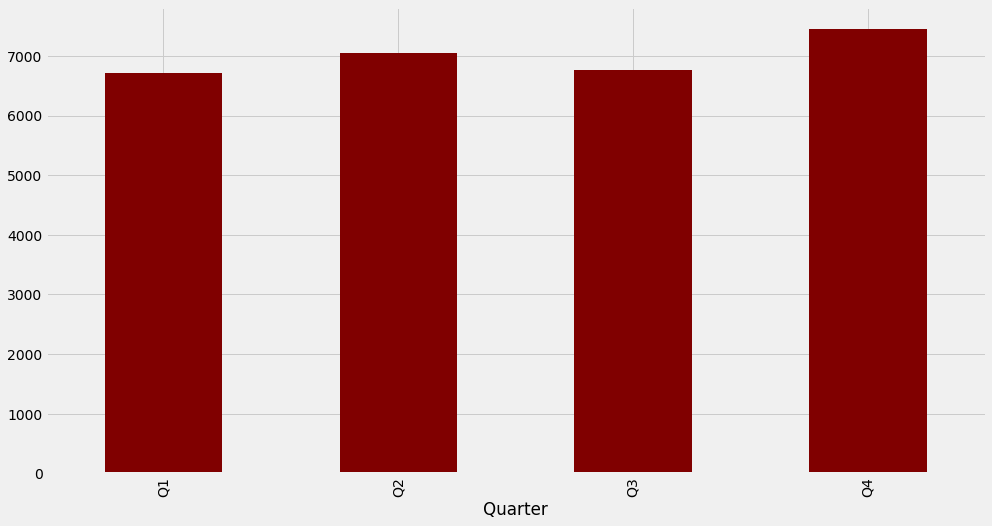

In [118]:
df['Quarter'] = df['Month'].apply(lambda x: 'Q1' if 1<= x <= 3
                                            else 'Q2' if 4 <= x <= 6
                                            else 'Q3' if 7 <= x <= 9
                                            else 'Q4' if 10 <= x <= 12
                                            else 'NA')
df.groupby(['Quarter'])['Sales'].mean().plot(kind = 'bar', color = 'maroon')

In [119]:
## Delete the Month and Year variable and 
## create dummies for the quarters

df = pd.get_dummies(df, columns = ['Quarter'], prefix = 'Quarter', drop_first = True)
df.drop(['Month', 'Year'], axis = 1, inplace = True)

## Also remove the one dummy for each
## of the newly merged variables

df.drop(['StoreType_a', 'Assortment_a', 'PromoInt_unk'], axis = 1, inplace = True)
df.shape

(844338, 28)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   Sales                      844338 non-null  int64  
 2   Customers                  844338 non-null  int64  
 3   Promo                      844338 non-null  int64  
 4   SchoolHoliday              844338 non-null  int64  
 5   StateHoliday_a             844338 non-null  uint8  
 6   StateHoliday_b             844338 non-null  uint8  
 7   StateHoliday_c             844338 non-null  uint8  
 8   DayOfWeek_2                844338 non-null  uint8  
 9   DayOfWeek_3                844338 non-null  uint8  
 10  DayOfWeek_4                844338 non-null  uint8  
 11  DayOfWeek_5                844338 non-null  uint8  
 12  DayOfWeek_6                844338 non-null  uint8  
 13  DayOfWeek_7                84

***Regression***

In [127]:
X = df.copy()
y = X.pop('Sales')

X.shape

(844338, 27)

In [129]:
## Splitting the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [131]:
## Fitting the model and estimating the parameters
## and making predictions

lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_val)

In [141]:
pd.DataFrame({'Columns' : X.columns, 'Coefficients' : lr.coef_})

,Columns,Coefficients
0,Store,-0.113912
1,Customers,7.300166
2,Promo,1288.224574
3,SchoolHoliday,173.453963
4,StateHoliday_a,163.350890
5,StateHoliday_b,-9.489855
6,StateHoliday_c,2566.981356
7,DayOfWeek_2,-481.651729
8,DayOfWeek_3,-621.367125
9,DayOfWeek_4,-698.036040
